In [176]:
import os
import keyring
import json
import operator
import functools

from typing import Annotated, Literal, List, Optional, TypedDict

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
from langchain_core.messages import HumanMessage, BaseMessage
from langgraph.prebuilt import create_react_agent

from langchain_community.document_loaders import WebBaseLoader
from langchain_core.tools import tool

from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage

# Setup for tools
OPENAI_API_KEY = keyring.get_password('openai', 'key_for_mac')
TAVILY_API_KEY = keyring.get_password('tavily', 'key_for_mac')
os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY
os.environ['TAVILY_API_KEY'] = TAVILY_API_KEY

# Set up LangSmith observability
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = "https://api.smith.langchain.com"
os.environ['LANGCHAIN_API_KEY'] = keyring.get_password('langsmith', 'learning_agent')
os.environ['LANGCHAIN_PROJECT'] = "pr-stupendous-hood-8"

In [177]:
# search search tool
search_tool = TavilySearchResults(max_results=5)

# Set web search and scraping tools
@tool
def scrape_webpages(urls: List[str]) -> str:
    """ Use requests and bs4 ro scrape the provideed web pages for detailed information. """
    loader = WebBaseLoader(urls)
    docs = loader.load()
    return "\n\n".join(
        [
            f"\n{doc.page_content}\n"
            for doc in docs
        ]
    )
    
# Define the tools
tools = [
    search_tool,
    # scrape_webpages
]

In [178]:
# Define a analysis agent

# FactCheckState graph state
class FactCheckState(TypedDict):
    # A message is added after each team member finishes
    messages: Annotated[List[BaseMessage], operator.add]
    # The team members are tracked so they are aware of the other's skill-sets
    team_members: List[str]
    # Used to route work. The supervisor calls a function that will update this every time it makes a decision
    next: str
    # The list of contention extracted from the query
    contentions: List[str]
    
llm = ChatOpenAI(model='gpt-4o-mini', temperature=0)


In [179]:
# Query Analysis Agent : Alicia
analysis_members = ["Alicia"]

analysis_system = """
You are a text analysis specialist in a Query Analysis Team.
Your primary role is to extract contentious issues from the input text that require fact-checking.
You should answer the same language as user's input.

# Your Responsibilities:
	1.	Analyze the input text for extracting contention:
Analyze the input text carefully to identify potential areas of controversy or claims requiring verification.
	2.	Extranc specific contentious iuuses:
Extract specific contentious issues, including any claims, statistics, or opinions that might spark debate or require validation.
  	3.	Review Extracted Contentious Issues:
Carefully analyze the issues provided by the query analyst, ensuring you fully understand the context and significance of each issue.
	4.	Summarize Issues Clearly and Concisely:
Create concise summaries that capture the essence of each contentious issue while ensuring clarity and relevance for fact-checking purposes.
	5.	Organize Summaries in a Structured Format:
Present the summarized issues in a clean and structured format that is easy to reference and understand.

# Output Format:
{
    "contentious_issues": [
        "Summarized issue 1",
        ...
    ]
}
"""

def analysis_agent_node(state, agent, name) -> FactCheckState:
    result = agent.invoke(state)
    try:
        output = json.loads(result["messages"][-1].content)
        summarized_issues = output.get("contentious_issues", [])
        if not summarized_issues:
            raise ValueError("Summarized contentions are empty.")
    except (json.JSONDecodeError, KeyError, ValueError) as e:
        summarized_issues = ["Error in summarizing contentions: " + str(e)]
    
    state['contensions'] = summarized_issues
    
    return {
        "messages": [HumanMessage(content=result["messages"][-1].content, name=name)],
        "contentions": summarized_issues,
    }

analysis_agent = create_react_agent(llm, tools=[], state_modifier=analysis_system)
analysis_node = functools.partial(analysis_agent_node, agent=analysis_agent, name="Alicia")
analysis_members = {
    "Analysis": "Alica"
}

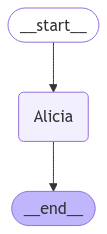

In [180]:
# Test the analysis agent
analysis_workflow = StateGraph(FactCheckState)
analysis_workflow.add_node("Alicia", analysis_node)
analysis_workflow.add_edge(START, "Alicia")
analysis_workflow.add_edge("Alicia", END)
analysis_graph = analysis_workflow.compile()

display(analysis_graph)

In [181]:
# several contentions
for s in analysis_graph.stream(
    {
        "messages": [HumanMessage(
            content="Recent studies suggest that over 70% of people globally support the use of artificial intelligence in law enforcement. However, critics argue that AI-based policing systems have led to a 50% increase in wrongful arrests due to algorithmic bias. Additionally, some governments claim that implementing AI surveillance has reduced crime rates by as much as 40%, but human rights organizations dispute these figures, stating that the data lacks transparency and reliability."
        )]
    }
):
    if "__end__" not in s:
        print(s)
        print("---")

{'Alicia': {'messages': [HumanMessage(content='{\n    "contentious_issues": [\n        "Claim that over 70% of people globally support the use of artificial intelligence in law enforcement.",\n        "Assertion that AI-based policing systems have led to a 50% increase in wrongful arrests due to algorithmic bias.",\n        "Government claim that implementing AI surveillance has reduced crime rates by as much as 40%.",\n        "Dispute from human rights organizations regarding the transparency and reliability of data supporting crime rate reductions due to AI surveillance."\n    ]\n}', additional_kwargs={}, response_metadata={}, name='Alicia')], 'contentions': ['Claim that over 70% of people globally support the use of artificial intelligence in law enforcement.', 'Assertion that AI-based policing systems have led to a 50% increase in wrongful arrests due to algorithmic bias.', 'Government claim that implementing AI surveillance has reduced crime rates by as much as 40%.', 'Dispute fr

In [182]:
# Several contentions
for s in analysis_graph.stream(
    {
        "messages": [HumanMessage(
            '수개표가 아닌 전자개표 방식을 고집하니, 대통령은 의혹 덩어리라고 생각되는 선관위에 대해 전면적인 강제 수사를 할 수 밖에 없다.'
        )]
    }
):
    if "__end__" not in s:
        print(s)
        print("---")

{'Alicia': {'messages': [HumanMessage(content='{\n    "contentious_issues": [\n        "대통령이 선관위에 대해 전면적인 강제 수사를 해야 한다는 주장",\n        "전자개표 방식에 대한 고집이 의혹을 불러일으킨다는 의견"\n    ]\n}', additional_kwargs={}, response_metadata={}, name='Alicia')], 'contentions': ['대통령이 선관위에 대해 전면적인 강제 수사를 해야 한다는 주장', '전자개표 방식에 대한 고집이 의혹을 불러일으킨다는 의견']}}
---


In [183]:
# one contention
for s in analysis_graph.stream(
    {
        "messages": [HumanMessage(
            '전자개표 방식에 대한 고집이 의혹을 불러일으킨다는 의견'
        )]
    }
):
    if "__end__" not in s:
        print(s)
        print("---")

{'Alicia': {'messages': [HumanMessage(content='{\n    "contentious_issues": [\n        "전자개표 방식에 대한 고집이 의혹을 불러일으킨다는 주장"\n    ]\n}', additional_kwargs={}, response_metadata={}, name='Alicia')], 'contentions': ['전자개표 방식에 대한 고집이 의혹을 불러일으킨다는 주장']}}
---


In [246]:
# Define reseach team state and agent node
class ResearchState(TypedDict):
    # A message is added after each team member finishes
    messages: Annotated[List[BaseMessage], operator.add]
    # The team members are tracked so they are aware of the other's skill-sets
    team_members: List[str]
    # Used to route work. The supervisor calls a function that will update this every time it makes a decision
    next: str
    # A contention extracted from the analysis agent
    contention: str
    # supporting evidence of a contention
    pros: List[str]
    # cons evidence of a contentsion
    cons: List[str]
    
    
def research_agent_node(state, agent, name, type) -> FactCheckState:
    result = agent.invoke(state)
    try:
        # Debug agent output
        content = result["messages"][-1].content.strip()
        print("Agent Output:", content)
        
        if not content:
            raise ValueError("Agent returned an empty response.")
        
        output = json.loads(content)
        evidences = output.get(type, [])
        if not evidences:
            raise ValueError(f"No '{type}' found in the output.")
    except (json.JSONDecodeError, KeyError, ValueError) as e:
        evidences = [f"Error in researching evidences: {str(e)}"]
    
    # Safely update the state
    state[type] = state.get(type, []) + evidences
    
    return {
        "messages": [HumanMessage(content=result["messages"][-1].content, name=name)],
        type: evidences,
    }

In [247]:
# Define a research team
## Research team consists of two members : one for pros "Jefferson" another for cons "John"
research_members = {
    "research_pros": "Jefferson",
    "research_cons": "John",
    "evalute": "Washington"
}

# Pros agent

research_pros_system = """
You are a specialist tasked with researching supporting evidence for the contentions provided by the Analysis team (Alicia). 
Your goal is to verify the factual accuracy of the contentions by finding credible evidence and summarizing it concisely. 

### Responsibilities:
1.	Research Facts:
•	Use appropriate tools and reliable sources to verify the truth of each contention.
•	Ensure all sources used are credible, relevant, and up-to-date.
2.	Provide Supporting Evidence:
•	For each contention, gather multiple pieces of supporting evidence.
•	Include links to the sources used, ensuring they directly support or refute the contention.
3.	Summarize Evidence:
•	Summarize the evidence clearly and concisely to ensure it is actionable for fact-checking purposes.
•	Focus on clarity and relevance.

### **Guidelines**:
- **Objectivity**: Evaluate the contention impartially, using reliable evidence to refute its validity.
- **Clarity**: Ensure the evidence is summarized in a concise and easy-to-understand manner.
- **Credibility**: Use only reputable sources, such as scientific journals, institutional reports, and trusted news outlets.
- **Format Consistency**: Ensure all evidence summaries follow the specified output format.
- **Language**: YOU SHOULD ANSHWER THE SAME LANGAUGE AS THE HUMAN'S INPUT 


### Output Format:
{
    "contention": "<The original contentious statement>",
    "pros": [
        "<Evidence summary 1> Source: <URL of reference>", ...
    ]
}


## Example output format:
{
    "contention": "The claim that drinking eight glasses of water a day improves health and prevents chronic diseases is contentious, with some scientists arguing there is no universal scientific basis for this recommendation, necessitating further investigation into hydration guidelines.",
    "pros": [
        "The recommendation to drink eight glasses of water daily lacks robust scientific support. Hydration needs vary based on factors like age, activity level, and climate. Source: https://www.healthline.com/nutrition/8-glasses-of-water-per-day?utm_source=chatgpt.com",
        "Experts suggest using thirst as a natural indicator for when to drink water rather than adhering to a fixed amount. Source: https://sciencebasedmedicine.org/eight-glasses-of-water-myth/",
        "Various beverages and foods contribute to overall hydration, not just plain water. Source: https://www.michiganmedicine.org/health-lab/myth-busting-no-more-8-glasses-day"
    ]
}
"""
research_pros_agent = create_react_agent(llm, tools=tools, state_modifier=research_pros_system)
research_pros_node = functools.partial(research_agent_node, agent=research_pros_agent, name="Jefferson", type="pros")

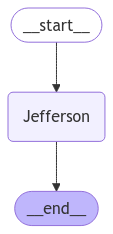

In [248]:
# Test research agent
research_pro_workflow = StateGraph(ResearchState)
research_pro_workflow.add_node("Jefferson", research_pros_node)
research_pro_workflow.add_edge(START, "Jefferson")
research_pro_workflow.add_edge("Jefferson", END)
research_pro_graph = research_pro_workflow.compile()

display(research_pro_graph)

In [249]:
# one contention
for s in research_pro_graph.stream(
    {
        "messages": [HumanMessage(
            '전자개표 방식에 대한 고집이 의혹을 불러일으킨다는 의견'
        )]
    }
):
    if "__end__" not in s:
        print(s)
        print("---")

Agent Output: {
    "contention": "전자개표 방식에 대한 고집이 의혹을 불러일으킨다는 의견",
    "pros": [
        "전자개표기 도입 이후 부정선거 의혹이 지속적으로 제기되고 있으며, 특히 한국과 미국의 전자개표기 사용에 대한 논란이 커지고 있다. 전문가들은 전자개표기가 투표 결과를 조작할 수 있는 가능성을 지적하고 있다. Source: https://m.blog.naver.com/shltop/222146067278",
        "한국의 전자개표기 시스템이 부정선거와 관련된 의혹을 받고 있으며, 이는 미국 대선의 도미니언 시스템과 유사한 방식으로 조작될 수 있다는 주장이 있다. Source: https://m.fntoday.co.kr/news/articleView.html?idxno=239774",
        "부정선거 의혹은 전자개표기 납품업체의 양심고백과 관련된 사건들로 인해 더욱 심화되고 있으며, 이는 선거 과정의 공정성에 대한 의문을 불러일으키고 있다. Source: https://m.blog.naver.com/henrynkoh/223694212383",
        "전자개표기와 관련된 부정선거 의혹은 한국의 선거 시스템에 대한 신뢰를 저하시킬 수 있으며, 이는 민주주의의 핵심인 선거의 투명성을 위협하는 요소로 작용할 수 있다. Source: http://www.fntoday.co.kr/news/articleView.html?idxno=342224"
    ]
}
{'Jefferson': {'messages': [HumanMessage(content='{\n    "contention": "전자개표 방식에 대한 고집이 의혹을 불러일으킨다는 의견",\n    "pros": [\n        "전자개표기 도입 이후 부정선거 의혹이 지속적으로 제기되고 있으며, 특히 한국과 미국의 전자개표기 사용에 대한 논란이 커지고 있다. 전문가들은 전자개표기가 투표 결과를 조작할 수 있는 가능성을 지적하고 있다. 

In [250]:
# Cons agent

research_cons_system = """
You are a research specialist tasked with identifying and summarizing credible evidence against the contentions provided by the Analysis team (Alicia). 
Your goal is to refute the validity of each contention by gathering and presenting reliable evidence clearly and concisely.

---

### Responsibilities:
1.	Research Facts:
•	Use appropriate tools and reliable sources to verify the truth of each contention.
•	Ensure all sources used are credible, relevant, and up-to-date.
2.	Provide Supporting Evidence:
•	For each contention, gather multiple pieces of supporting evidence.
•	Include links to the sources used, ensuring they directly support or refute the contention.
3.	Summarize Evidence:
•	Summarize the evidence clearly and concisely to ensure it is actionable for fact-checking purposes.
•	Focus on clarity and relevance.

### **Guidelines**:
- **Objectivity**: Evaluate the contention impartially, using reliable evidence to refute its validity.
- **Clarity**: Ensure the evidence is summarized in a concise and easy-to-understand manner.
- **Credibility**: Use only reputable sources, such as scientific journals, institutional reports, and trusted news outlets.
- **Format Consistency**: Ensure all evidence summaries follow the specified output format.
- **Language**: YOU SHOULD ANSHWER THE SAME LANGAUGE AS THE HUMAN'S INPUT 

### Output Format:
{
    "contention": "<The original contentious statement>",
    "cons": [
        "<Evidence summary 1> Source: <URL of reference>", ...
    ]
}


## Example output format:
{
    "contention": "The claim that drinking eight glasses of water a day improves health and prevents chronic diseases is contentious, with some scientists arguing there is no universal scientific basis for this recommendation, necessitating further investigation into hydration guidelines.",
    "cons": [
        "The recommendation to drink eight glasses of water daily lacks robust scientific support. Hydration needs vary based on factors like age, activity level, and climate. Source: https://www.healthline.com/nutrition/8-glasses-of-water-per-day?utm_source=chatgpt.com",
        "Experts suggest using thirst as a natural indicator for when to drink water rather than adhering to a fixed amount. Source: https://sciencebasedmedicine.org/eight-glasses-of-water-myth/",
        "Various beverages and foods contribute to overall hydration, not just plain water. Source: https://www.michiganmedicine.org/health-lab/myth-busting-no-more-8-glasses-day"
    ]
}
"""
research_cons_agent = create_react_agent(llm, tools=tools, state_modifier=research_cons_system)
research_cons_node = functools.partial(research_agent_node, agent=research_cons_agent, name="John", type="cons")

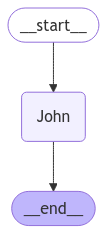

In [251]:
# Test research agent
research_cons_workflow = StateGraph(ResearchState)
research_cons_workflow.add_node("John", research_cons_node)
research_cons_workflow.add_edge(START, "John")
research_cons_workflow.add_edge("John", END)
research_cons_graph = research_cons_workflow.compile()

display(research_cons_graph)

In [252]:
# one contention
for s in research_cons_graph.stream(
    {
        "messages": [HumanMessage(
            '전자개표 방식에 대한 고집이 의혹을 불러일으킨다는 의견'
        )]
    }
):
    if "__end__" not in s:
        print(s)
        print("---")

Agent Output: {
    "contention": "전자개표 방식에 대한 고집이 의혹을 불러일으킨다는 의견",
    "cons": [
        "중앙선거관리위원회는 전자개표 과정에서 의도적인 오류가 발생할 가능성이 없다고 주장하며, 전자개표기의 정확도는 100%에 달한다고 보고하고 있습니다. Source: https://m.post.naver.com/viewer/postView.nhn?volumeNo=7332257&memberNo=29442882",
        "부정선거 의혹은 전자개표 방식에 대한 불신에서 비롯되지만, 전문가들은 투명한 선거 시스템 구축과 독립적인 기술위원회의 검증을 통해 신뢰성을 높일 수 있다고 강조하고 있습니다. Source: https://www.etoday.co.kr/news/view/2432600",
        "수검표 과정은 전자개표 결과를 검증하기 위한 절차로, 모든 투표지를 다시 세는 것이 아니라 오류와 무효표 여부를 확인하는 데 초점을 맞추고 있습니다. 이는 전자개표 방식의 신뢰성을 보완하는 역할을 합니다. Source: https://stranger-jy.tistory.com/1138"
    ]
}
{'John': {'messages': [HumanMessage(content='{\n    "contention": "전자개표 방식에 대한 고집이 의혹을 불러일으킨다는 의견",\n    "cons": [\n        "중앙선거관리위원회는 전자개표 과정에서 의도적인 오류가 발생할 가능성이 없다고 주장하며, 전자개표기의 정확도는 100%에 달한다고 보고하고 있습니다. Source: https://m.post.naver.com/viewer/postView.nhn?volumeNo=7332257&memberNo=29442882",\n        "부정선거 의혹은 전자개표 방식에 대한 불신에서 비롯되지만, 전문가들은 투명한 선거 시스템 구축과 독립적인 기술위원회의 검증을 통해 신뢰성을 높일 수 있다고 강조하

In [253]:
# Research evaluator
def agent_node(state, agent, name):
    result = agent.invoke(state)
    # extracted_contentions = result.get("contentions", [])
    return {
        "messages": [HumanMessage(content=result["messages"][-1].content, name=name)], 
    }


research_evaluate_system = """
You are a specialist tasked with verifying the factual accuracy of contentions by evaluating various pieces of information. 
Your primary responsibility is to assess the validity of the contention, assign a factual score, and provide a detailed explanation.

### Responsibilities:
1. Review information: 
	• Utilize all available information from both supporting and opposing parties.
 	• If additional information is needed, request further research from your team members.
 	• If you need research by your own, use tools.  
  	• Ensure you have sufficient information before proceeding to the next step.
2. Assign a Factual Score:
	• Provide a factuality score between **0 and 100**, where:
        - `0`: Completely false.
        - `25`: Mostly false, but contains minor elements of truth.
        - `50`: Neutral or inconclusive.
        - `75`: Mostly true, but contains minor inaccuracies.
        - `100`: Completely true.
	• Include an explanation for your score, especially if the score is not 100 or 0.
3. Provide Supporting Evidence: Include links to the sources used for your research. Ensure the sources are credible and relevant.

### **Guidelines**:
- **Objectivity**: Maintain impartiality and evaluate the contention based on the evidence.
- **Clarity**: Ensure your explanations are concise, clear, and actionable.
- **Credibility**: Use reliable and authoritative sources (e.g., peer-reviewed articles, reputable news outlets, or institutional reports).
- **Collaboration**: If necessary, collaborate with your team or tools to gather additional information.
- **Language**: YOU SHOULD ANSHWER THE SAME LANGAUGE AS THE HUMAN'S INPUT 

### **Output Format**:
Provide your response in the following structured format:
{
    "contention": "<The original contentious statement>",
    "score": <Factual score between 0 and 100>,
    "explanation": "<Detailed explanation for the assigned score>",
    "sources": [
        "<URL of reference 1>",
        "<URL of reference 2>",
        ...
    ]
}
"""
research_evaluate_agent = create_react_agent(llm, tools=tools, state_modifier=research_evaluate_system)
research_evaluate_node = functools.partial(agent_node, agent=research_evaluate_agent, name="Washington")

In [254]:
# Research team supervisor
def create_team_supervisor(llm: ChatOpenAI, system_prompt, members) -> str:
    """An LLM-Based router"""
    options = ["FINISH"] + members
    
    # Define a function for OpenAI function calling : https://platform.openai.com/docs/guides/function-calling
    function_def = {
        "name": "route",
        "description": "Select the next role and provide clear instructions for the selected role to carry out",
        "parameters": {
            "title": "routeSchema",
            "type": "object",
            "properties": {
                "next": {
                    "title": "Next",
                    "anyOf": [
                        {"enum": options},
                    ]
                }
            },
            "required": ["next"],
        }
    }
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next?"
                " or should we FINISH?, select one of : {options}"
            )
        ]
    ).partial(options=str(options), team_members=", ".join(members))
    return (
        prompt
        | llm.bind_functions(functions=[function_def], function_call="route")
        | JsonOutputFunctionsParser()
    )

research_supervisor_agent = create_team_supervisor(
    llm,
    """Your team is responsible for researching cons and pros about the contention.
    As the supervisor, you are tasked with managing a conversation between the following workers: Jefferson and John.

    Responsibilities:
        1.	Manage Task Assignment:
        •	Evaluate the user input and decide which worker, Jefferson or John, should act next based on their expertise.
        •	If a worker’s output requires additional refinement or improvements, assign them further tasks.
        2.	Evaluate Outputs:
        •	Review the results provided by each worker.
        •	If the output is satisfactory, assign the next worker or conclude the process.
        3.	Complete the Process:
        •	Once all contentious issues have been identified and summarized, respond with “FINISH” to conclude the task.

    Guidelines:
        •	Assign tasks efficiently to ensure the process moves forward productively.
        •	Provide constructive feedback to workers if their outputs need improvement.
        •	Ensure that the final output is clear, concise, and actionable for the fact-finding team.
        •	YOU SHOULD ANSHWER THE SAME LANGAUGE AS THE HUMAN'S INPUT 

    ### Output Instructions:
    Respond with a valid JSON object formatted as follows:
    "next": "Research Pros",  // Replace "Research Pros" with "Research Cons", "Evaluate" or "FINISH" as appropriate.
    "instructions": "You need get more contentions. Check the numbers."
    """,
    ["Research Pros", "Research Cons", "Evaluate"],
)

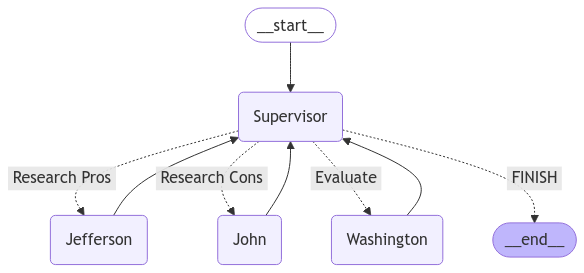

In [255]:
# Definte StateGraph and add nodes
research_workflow = StateGraph(ResearchState)
research_workflow.add_node("Jefferson", research_pros_node)
research_workflow.add_node("John", research_cons_node)
research_workflow.add_node("Supervisor", research_supervisor_agent)
research_workflow.add_node("Washington", research_evaluate_node)

# Define edges for agents to return to the supervisor
for idx, type in enumerate(research_members):
    member = research_members[type]
    research_workflow.add_edge(member, 'Supervisor')

# Define conditional edges
research_workflow.add_conditional_edges(
    "Supervisor",
    lambda x: x["next"],
    {
        "Research Pros":"Jefferson",
        "Research Cons":"John",
        "Evaluate":"Washington",
        "FINISH":END
    }
)
research_workflow.add_edge(START, "Supervisor")

research_graph = research_workflow.compile()
display(research_graph)

In [256]:
# one contention
for s in research_graph.stream(
    {
        "messages": [HumanMessage(
            '인류 달 착륙이 거짓이다.'
        )]
    }
):
    if "__end__" not in s:
        print(s)
        print("---")

{'Supervisor': {'next': 'Research Cons'}}
---
Agent Output: {
    "contention": "인류 달 착륙이 거짓이다.",
    "cons": [
        "모든 달 착륙이 조작되었다는 주장은 신뢰할 수 있는 증거에 의해 반박되었습니다. NASA는 달 착륙의 진위를 입증하기 위해 다양한 과학적 데이터를 제공하고 있습니다. Source: https://www.iop.org/explore-physics/moon/how-do-we-know-we-went-to-the-moon",
        "달에서의 사진에서 깃발이 바람에 펄럭이는 것처럼 보이는 것은 실제로는 깃발이 특별히 설계된 구조로 인해 발생한 현상입니다. 달에는 공기가 없기 때문에 바람이 존재하지 않습니다. Source: https://www.history.co.uk/articles/debunking-the-biggest-moon-landing-conspiracy-theories",
        "달 착륙 사진의 그림자가 비정상적으로 보인다는 주장은 조명과 사진의 특성으로 설명될 수 있으며, 이는 과학적으로 입증된 사실입니다. Source: https://www.history.com/news/moon-landing-fake-conspiracy-theories",
        "아폴로 11 미션에서 설치된 레트로리플렉터는 지구에서 관측 가능하며, 이는 인간이 달에 착륙했음을 증명하는 중요한 증거입니다. Source: https://en.wikipedia.org/wiki/Moon_landing_conspiracy_theories"
    ]
}
{'John': {'messages': [HumanMessage(content='{\n    "contention": "인류 달 착륙이 거짓이다.",\n    "cons": [\n        "모든 달 착륙이 조작되었다는 주장은 신뢰할 수 있는 증거에 의해 반박되었습니다. NASA는 달 착륙의 진위를 입증

In [257]:
research_members

{'research_pros': 'Jefferson',
 'research_cons': 'John',
 'evalute': 'Washington'}

In [258]:
# for idx, type in enumerate(research_members):
#     member = research_members[type]
#     research_workflow.add_edge(member, 'Supervisor')

In [259]:
analysis_members | research_members

{'Analysis': 'Alica',
 'research_pros': 'Jefferson',
 'research_cons': 'John',
 'evalute': 'Washington'}